In [4]:
import numpy as np
import os
import segyio

from pyfrac.visualisation.plotting_support import explode_volume
from pylops.basicoperators import FirstDerivative
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
expname = 'expSetUp'
projpath = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI_LargeRockBlock_Sandstone/expSetUp/'
snappath = os.path.join(projpath,'outputs/snap/')
seispath = os.path.join(projpath,'outputs/su/')

In [62]:
nx,nz,ny = (504, 452, 504)
dx = dy = dz = 0.001 

nr = 9126

# SNAPS

In [49]:
snap_sbsmp = 2
snap_file = os.path.join(snappath,'%s.bin.vy'%expname)

p_snaps_1d = np.fromfile(snap_file,dtype='<f')

snap_nx = int(nx/snap_sbsmp )
snap_ny = int(ny/snap_sbsmp )
snap_nz= int(nz/snap_sbsmp )
nsnaps = int(p_snaps_1d.shape[0]/(snap_nx*snap_ny*snap_nz))

p_snaps = p_snaps_1d.reshape([nsnaps, snap_nx, snap_ny, snap_nz])
p_snaps = np.transpose(p_snaps,[0,3,1,2])
# p_snaps = p_snaps/np.max(abs(p_snaps))

In [50]:
np.unravel_index(np.argmax(p_snaps),p_snaps.shape)

(31, 100, 124, 125)

In [51]:
p_snaps.shape

(52, 226, 252, 252)

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

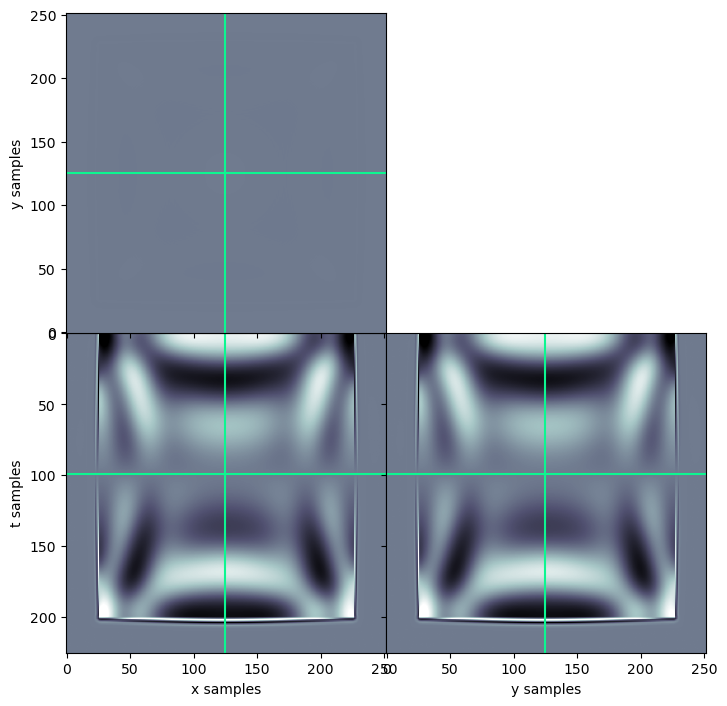

In [59]:
explode_volume(p_snaps[49], p=99.8, x=125, t=99, y=125)

IndexError: index 52 is out of bounds for axis 0 with size 52

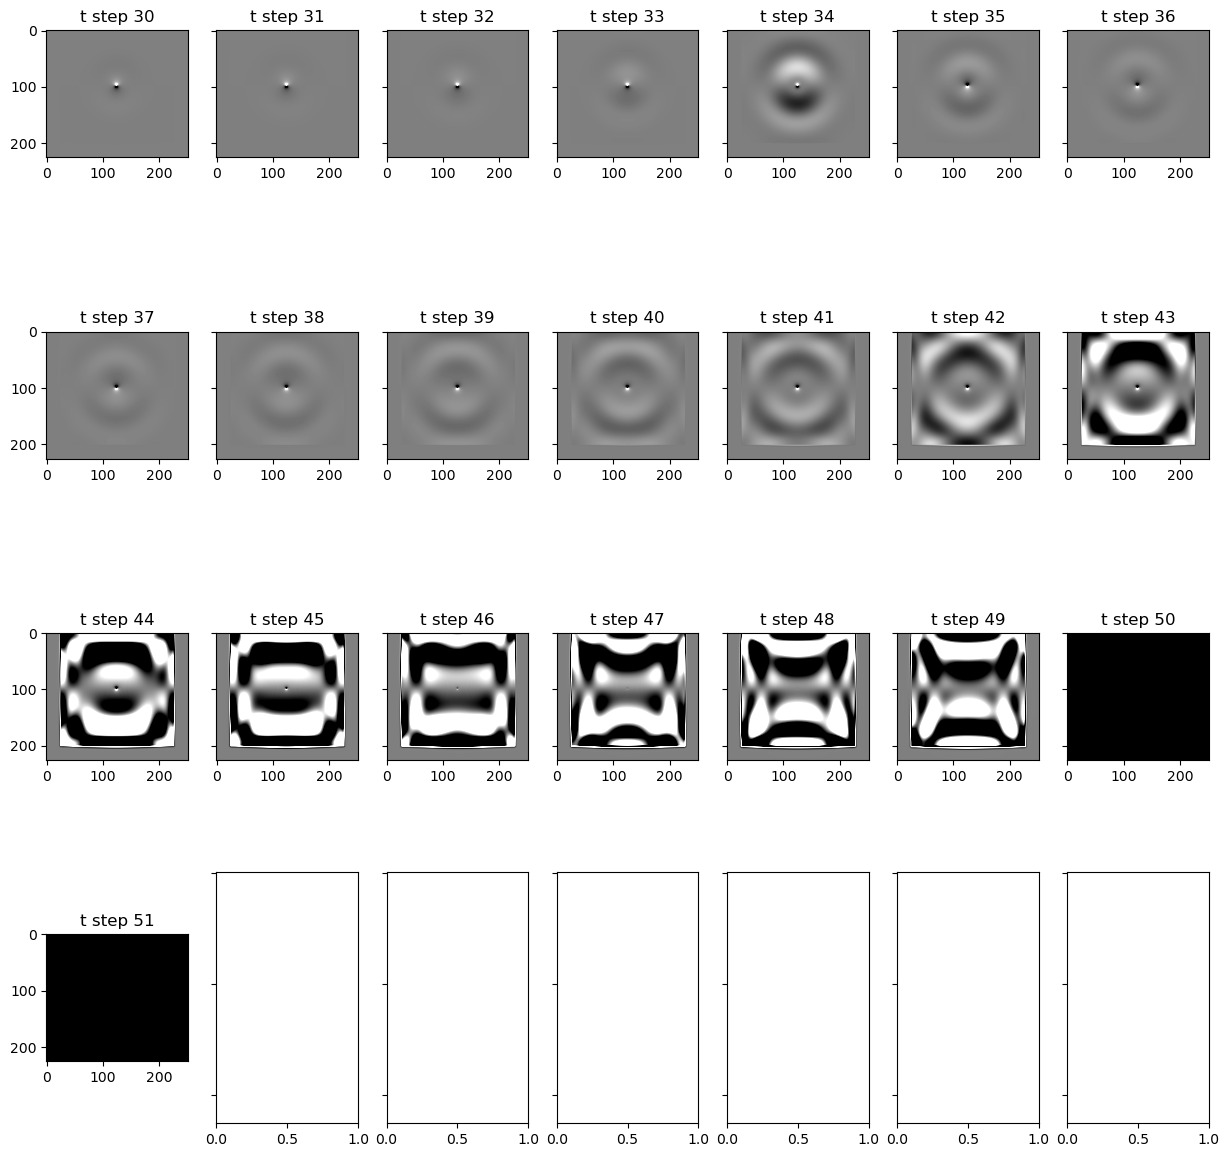

In [57]:
fig,axs = plt.subplots(4,7, figsize=[15,15], sharey=True)
for i,ax in enumerate(axs.ravel()):
    ax.imshow(p_snaps[i+30,:,:,125]/np.max(abs(p_snaps[i+30,:,:,125])),  
                          cmap='binary', vmin=-0.1, vmax=0.1, 
                         )
    ax.set_title('t step %i'%(i+30))
# for ax in axs.ravel(): ax.set_yticks([]); ax.set_xticks([])
plt.tight_layout()

# Receivers

In [8]:
def strain_from_velocity(perp_velocity):
    '''
    perp_velocity follow pytorch dims: 'instance'-by-x-by-t
    e.g., [cable_no, x, t]
    where x is axis over which to differentiate
    '''
    # handle if only 1 instance, i.e. single rec line
    if len(perp_velocity.shape)==2: 
        perp_velocity = np.expand_dims(perp_velocity,axis=0)
    
    # Make differential operator
    diffOp = FirstDerivative(dims=perp_velocity.shape, 
                             axis=1, 
                             order=5)
    
    # Take differentiate over velocity direction
    strain = diffOp@perp_velocity
    
    return strain

In [63]:
vz_file = os.path.join(seispath,'%s_vz.txt'%expname)
# s_wave_file = os.path.join(data_path,'test.bin.curl')

vz_flat = np.loadtxt(vz_file)
nt = int(vz_flat.shape[0]/nr)
print('nt:%i, nr:%i'%(nt,nr))
try: 
    vz_flat.reshape((nr,nt))
except:
    print('Not good dims \n nt:%i nr:%i \n vz flat:%i'%(nt,nr,vz_flat.shape[0]))
    
vz = vz_flat[:nt*nr].reshape((nr,nt))
print(np.max(vz))


nt:2000, nr:9126
0.0002267168


Text(0.5, 0, 'receiver #')

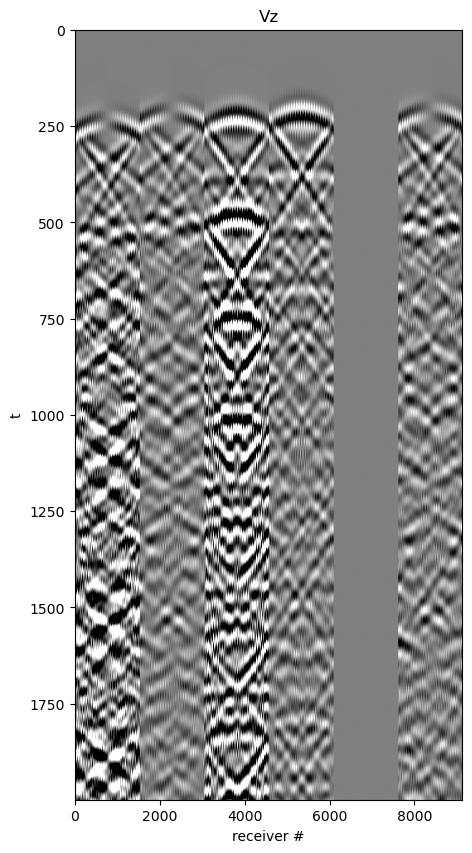

In [64]:
vlim=np.percentile(vz,92)
              
plt.figure(figsize=[5,10])
plt.imshow(vz[:,:2500].T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)
plt.title('Vz')
plt.ylabel('t')
plt.xlabel('receiver #')

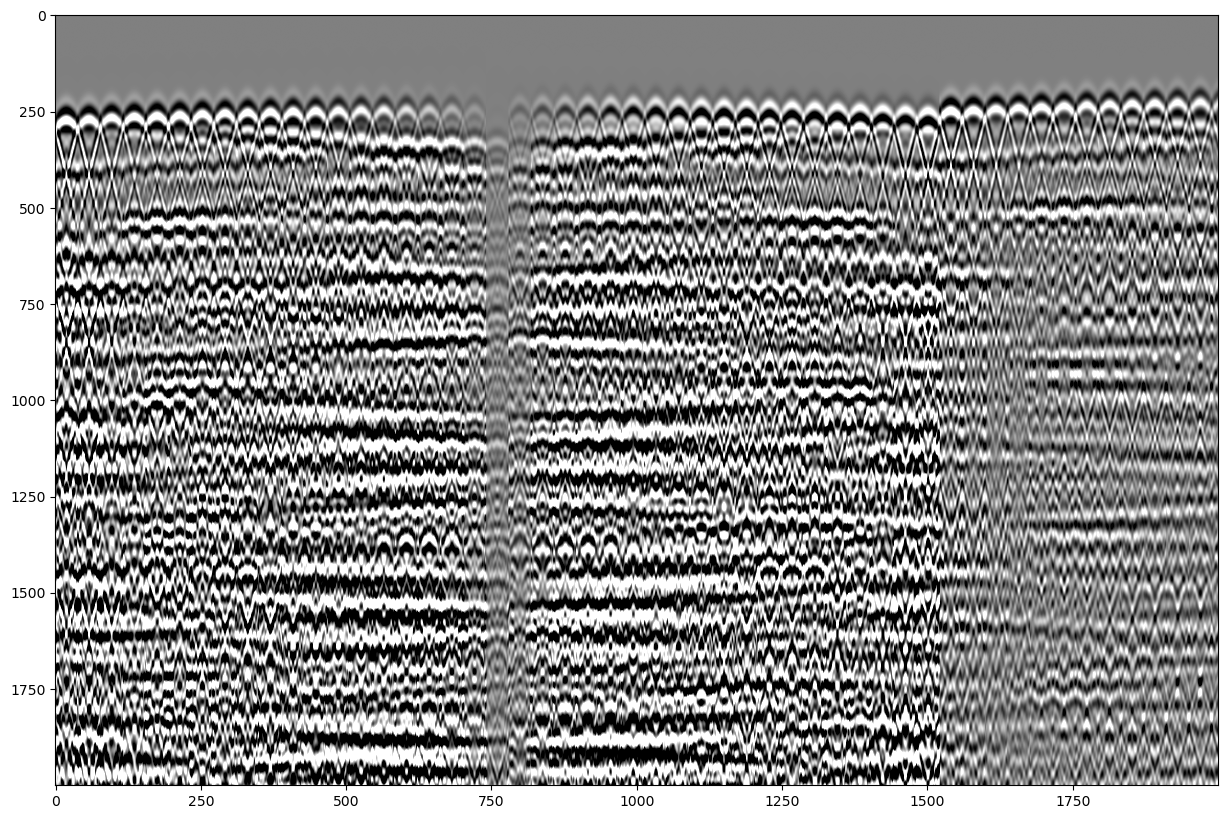

In [65]:
plt.figure(figsize=[15,10])
plt.imshow(vz[:2000,:2000].T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)

Text(0.5, 0, 'receiver #')

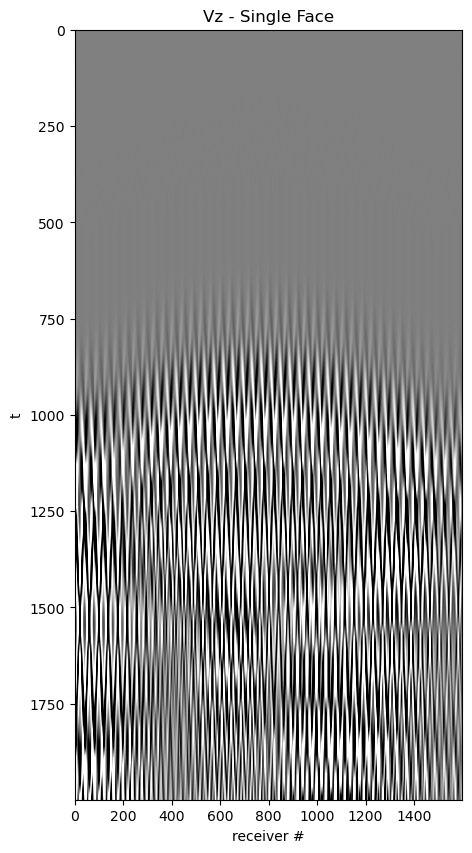

In [31]:
vz_face0 = vz[:40**2,:2000]

plt.figure(figsize=[5,10])
plt.imshow(vz_face0.T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)
plt.title('Vz - Single Face')
plt.ylabel('t')
plt.xlabel('receiver #')

In [33]:
vz_cubed = vz_face0.reshape([int(np.sqrt(vz_face0.shape[0])),int(np.sqrt(vz_face0.shape[0])),vz_face0.shape[1]])

In [34]:
vz_cubed.shape

(40, 40, 2000)

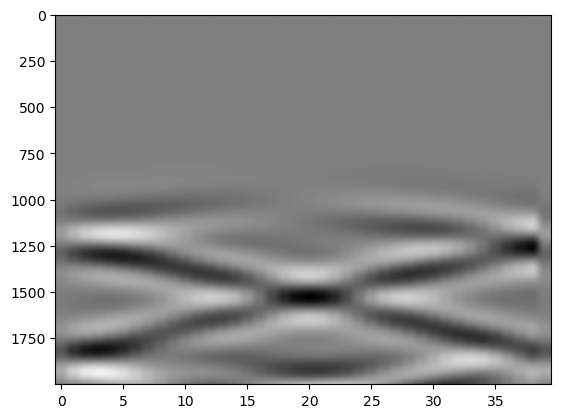

In [35]:
plt.imshow((vz_cubed[0]/np.max(abs(vz_cubed[0]))).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)

In [55]:
diffOp = FirstDerivative(dims=vz_cubed.shape, axis=1, order=5)

In [56]:
strain_z = diffOp@vz_cubed

In [57]:
strain_z.shape

(40, 40, 2000)

Text(0.5, 0, 'receiver #')

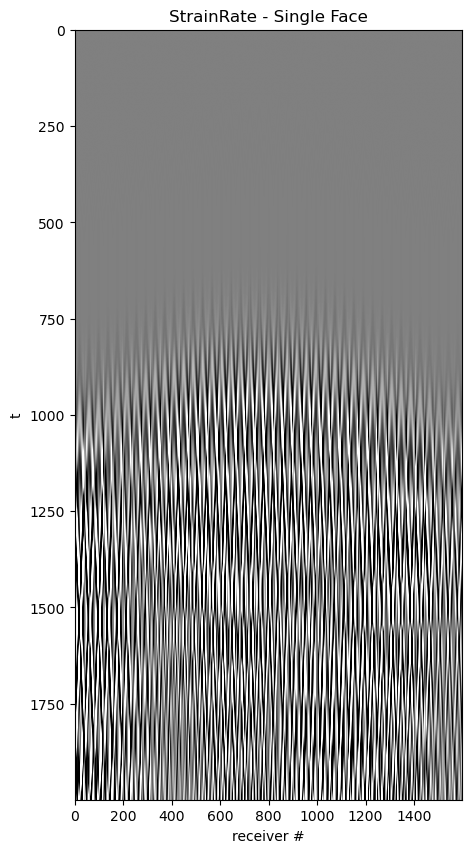

In [58]:
vlim=np.percentile(strain_z,90)
plt.figure(figsize=[5,10])
plt.imshow(strain_z.reshape([40**2,2000]).T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)
plt.title('StrainRate - Single Face')
plt.ylabel('t')
plt.xlabel('receiver #')

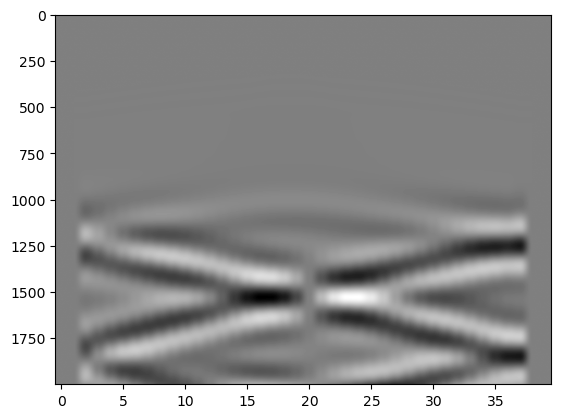

In [59]:
plt.imshow((strain_z[0]/np.max(abs(strain_z[0]))).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)

Text(0.5, 0, 'receiver #')

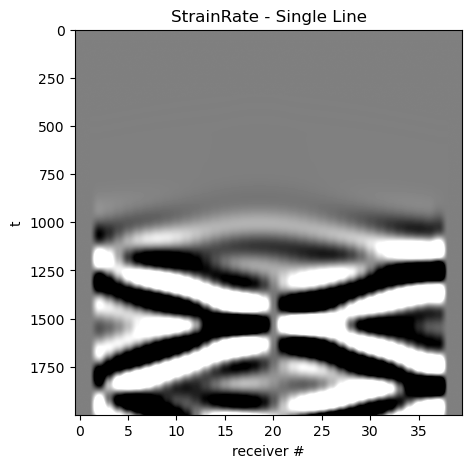

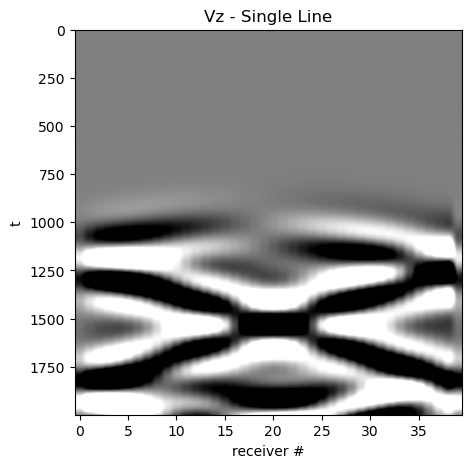

In [60]:
vlim=np.percentile(strain_z[0],90)
plt.figure(figsize=[5,5])
plt.imshow(strain_z[0].T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)
plt.title('StrainRate - Single Line')
plt.ylabel('t')
plt.xlabel('receiver #')

vlim=np.percentile(vz_cubed[0],90)
plt.figure(figsize=[5,5])
plt.imshow(vz_cubed[0].T, aspect='auto', cmap='binary', vmin=-1*vlim, vmax=1*vlim)
plt.title('Vz - Single Line')
plt.ylabel('t')
plt.xlabel('receiver #')

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

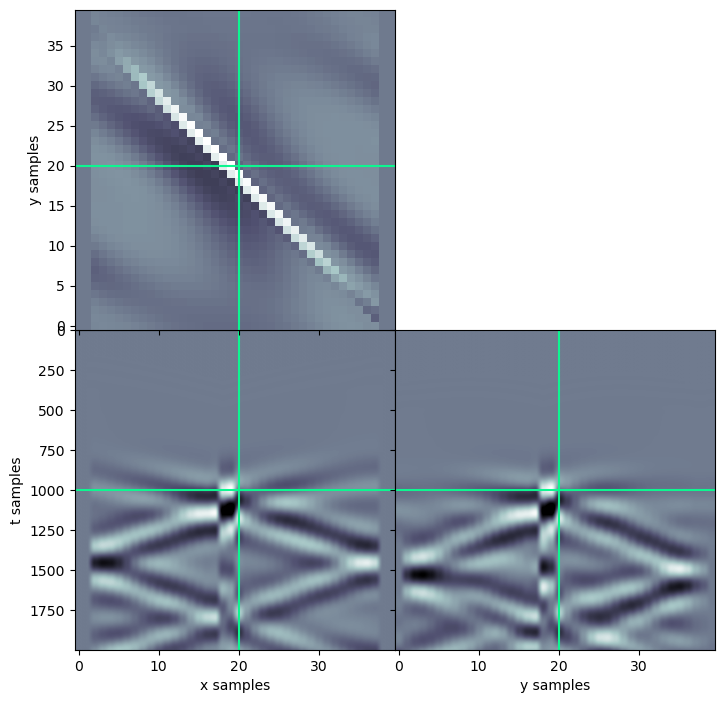

In [45]:
explode_volume(strain_z.transpose([2,1,0]), p=99.8,)